In [4]:
#Load dependencies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [5]:
#Data path
path = '/Volumes/Vincent SSD/KU Leuven/PhD AI-CS/Project Data/MNIST/'


#Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running on: {device}')

#Define dataloader class
class MNIST(Dataset):
    def __init__(self, X, y=None, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X.index)
    
    def __getitem__(self, index):
        image = self.X.iloc[index, ].values.astype(np.uint8).reshape((28, 28, 1))
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.y is not None:
            return image, self.y.iloc[index]
        else:
            return image



Running on: cpu


In [6]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

print(train_df.shape)
print(test_df.shape)

(60000, 785)
(10000, 785)


In [7]:
X_train, X_valid, y_train, y_valid = \
    train_test_split(train_df.iloc[:, 1:], train_df['label'], test_size=1/6, random_state=42)

y_test = test_df.pop('label')
X_test = test_df

print('train image shape : ', X_train.shape)
print('train label shape : ', y_train.shape)
print('valid image shape : ', X_valid.shape)
print('valid label image : ', y_valid.shape)
print('test image shape  : ', X_test.shape)
print('test label image : ', y_test.shape)




train image shape :  (50000, 784)
train label shape :  (50000,)
valid image shape :  (10000, 784)
valid label image :  (10000,)
test image shape  :  (10000, 784)
test label image :  (10000,)


In [8]:
transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

train_dataset = MNIST(X=X_train, y=y_train, transform=transform)
valid_dataset = MNIST(X=X_valid, y=y_valid, transform=transforms.ToTensor())
test_dataset = MNIST(X=X_test, y=y_test, transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

images, labels = next(iter(train_loader))

print('images shape on PyTroch : ', images.size())
print('labels shape on PyTroch : ', labels.size())



images shape on PyTroch :  torch.Size([128, 1, 28, 28])
labels shape on PyTroch :  torch.Size([128])


In [9]:
# Define model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )
        
    def forward(self, x):
        # convert tensor (128, 1, 28, 28) --> (128, 1*28*28)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        return x

model = MLP()
print(model)

#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()




MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=10, bias=True)
  )
)


In [10]:
#Define the training + validation loops
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 15

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (images, labels) in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        if (i * 128) % (128 * 100) == 0:
            print(f'{i * 128} / 50000')
            
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(valid_loader):
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            valid_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    
    accuracy = 100*correct/total
    valid_acc_list.append(accuracy)
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}, valid acc : {:.2f}%'\
         .format(epoch+1, np.mean(train_losses), np.mean(valid_losses), accuracy))



0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 1, train loss : 0.4282, valid loss : 0.1785, valid acc : 94.88%
0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 2, train loss : 0.1682, valid loss : 0.1178, valid acc : 96.39%
0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 3, train loss : 0.1182, valid loss : 0.1012, valid acc : 96.80%
0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 4, train loss : 0.0963, valid loss : 0.0819, valid acc : 97.40%
0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 5, train loss : 0.0808, valid loss : 0.0742, valid acc : 97.76%
0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 6, train loss : 0.0702, valid loss : 0.0722, valid acc : 97.97%
0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 7, train loss : 0.0641, valid loss : 0.0700, valid acc : 97.80%
0 / 50000
12800 / 50000
25600 / 50000
38400 / 50000
epoch : 8, train loss : 0.0574, valid loss : 0.0692, valid acc : 97.91%
0 / 5000

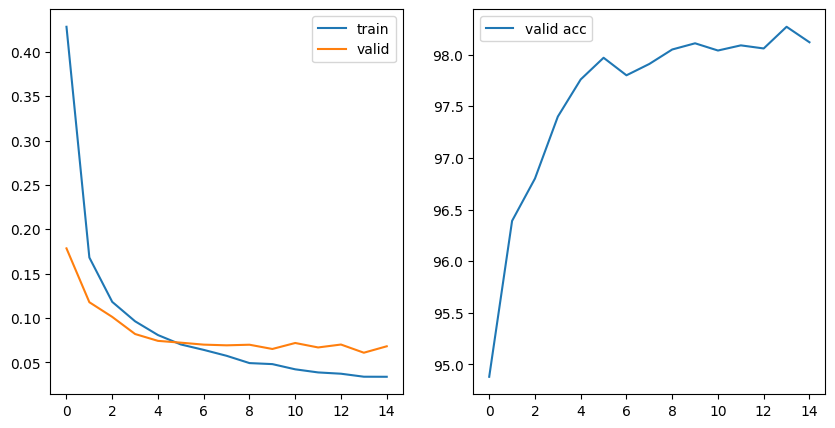

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax1.plot(mean_train_losses, label='train')
ax1.plot(mean_valid_losses, label='valid')
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='best')

ax2.plot(valid_acc_list, label='valid acc')
ax2.legend()
# plt.savefig(path + "/losses")



In [12]:
mean_test_losses = []
valid_test_list = []
test_losses = []

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        test_losses.append(loss.item())
        
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        

mean_test_losses.append(np.mean(test_losses))

accuracy = 100*correct/total
valid_test_list.append(accuracy)
print('test loss : {:.4f}, test acc : {:.2f}%'\
        .format(np.mean(test_losses), accuracy))

test loss : 0.0714, test acc : 97.95%
